In [1]:

import gpflow
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
from scipy.integrate import solve_ivp, odeint
from gpflow.utilities import print_summary, positive, to_default_float, set_trainable
from invariance_kernels import ZeroMean, get_MOI, get_pendulum_invariance, get_SHM_invariance, get_damped_pendulum_invariance, get_damped_SHM_invariance
from invariance_functions import degree_of_freedom, get_GPR_model, get_SHM_data, get_pendulum_data, get_damped_pendulum_data, get_damped_SHM_data, get_grid_of_points_1D, evaluate_model_future, evaluate_model_grid, SHM_dynamics, pendulum_dynamics, damped_SHM_dynamics, damped_pendulum_dynamics
from parameterised_invariance_kernels import get_polynomial_invariance, get_damped_polynomial_invariance
import os
os.environ["CUDA_VISIBLE_DEVICES"] = '1'

In [21]:

# %%
mean = ZeroMean(2)
time_step = 0.01
training_time = 0.1
testing_time = 3

max_x = 150
max_v = 10
data_eff_moi = []
data_eff_moi_trac = []

test_starting_position = np.radians(np.random.uniform(-max_x, max_x))
test_starting_velocity = np.radians(np.random.uniform(-max_v, max_v))

test_starting = (test_starting_position, test_starting_velocity)
time_setting = (testing_time, time_step)

for n_train in [1, 2, 5, 10]:
    train_starting_position = np.random.uniform(-max_x, max_x, (n_train))
    train_starting_velocity = np.random.uniform(-max_v, max_v, (n_train))

    print(train_starting_position)
    print(train_starting_velocity)
    data = get_pendulum_data(time_step, training_time, 1e-8, train_starting_position, train_starting_velocity) #switch

    moi = get_GPR_model(get_MOI(), mean, data, 500)
    print("moi:"+format(moi.log_marginal_likelihood().numpy(),".2f"))
    jitter = 5e-5
    invar_density = 40
    dynamics = pendulum_dynamics 
    def energy(X):
        return 0.5*tf.square(X[:,1])-np.cos(X[:,0])

    if n_train == 1:
        try:
            kernel = get_pendulum_invariance(np.radians(150), invar_density, jitter) #switch
            known = get_GPR_model(kernel, mean, data, 500)
        except tf.errors.InvalidArgumentError:
            print("jitter too small")
        evaluate_invariance =evaluate_model_future(known, test_starting, dynamics,time_setting, energy)
        data_eff_inv = evaluate_invariance[0]

    evaluate_moi = evaluate_model_future(moi, test_starting, dynamics,time_setting, energy)


    data_eff_moi.append(evaluate_moi[0])
    data_eff_moi_trac.append(evaluate_moi)

    


[51.25951225]
[-0.21993438]
moi:73.86
[  78.7200347  -144.43214581]
[-4.65717829 -5.05344534]
moi:149.98
[  75.97246945 -126.40311375 -141.49931166  -64.64011142   -1.84116823]
[ 8.66742416  0.1384964  -8.42676604  8.9637803  -1.01612528]
moi:403.56
[  25.06983037   10.89879572 -126.49254034   58.17723428  -44.87249856
  -61.74694445   47.27580351   64.77728757   93.98583583  -54.42035194]
[-7.91146061 -8.76282235  8.23783915 -5.35652057  4.13828799  6.70876438
 -7.2223269   7.42286592 -4.31579312 -3.63867302]
moi:868.03


In [3]:
data_eff_inv

0.002983801815028728

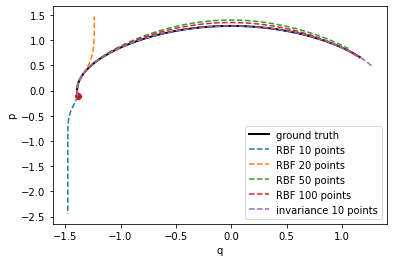

In [22]:

import matplotlib.pyplot as plt
fig, ax = plt.subplots()
plt.plot(evaluate_moi[4][:,0],evaluate_moi[4][:,1], label="ground truth", color="black", linewidth=2)
#plt.plot(evaluate_moi[1][:,0],evaluate_moi[1][:,1], "--", label='RBF', color="red")
plt.plot(data_eff_moi_trac[0][1][:,0],data_eff_moi_trac[0][1][:,1], "--", label='RBF 10 points')
plt.plot(data_eff_moi_trac[1][1][:,0],data_eff_moi_trac[1][1][:,1], "--", label='RBF 20 points')
plt.plot(data_eff_moi_trac[2][1][:,0],data_eff_moi_trac[2][1][:,1], "--", label='RBF 50 points')
plt.plot(data_eff_moi_trac[3][1][:,0],data_eff_moi_trac[3][1][:,1], "--", label='RBF 100 points')
plt.plot(evaluate_invariance[1][:,0],evaluate_invariance[1][:,1], "--", label="invariance 10 points")
plt.scatter(evaluate_moi[4][0,0],evaluate_moi[4][0,1],color="red")
plt.xlabel("q")
plt.ylabel("p")
plt.legend()
plt.savefig("figures/data_efficiency.pdf")